
# Visualizando un extractor 2D-CNN (Conv → BN → ReLU → Pool → Dropout) paso a paso

Este cuaderno genera un **mel-espectrograma sintético (65×41)** y muestra cómo se transforma
después de cada operación del extractor de características, **incluyendo visualizaciones**
y **dimensiones de los tensores**. Está pensado para explicación didáctica.

**Pipeline:**  
`Conv2D → BatchNorm → ReLU → MaxPool(3×3) → Dropout`  
`Conv2D → BatchNorm → ReLU → MaxPool(3×3) → Dropout` → `Flatten`


In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# No estilos ni colores específicos; matplotlib por defecto.
# (Recomendación: ejecutar todas las celdas en orden)

In [3]:

def print_shape(name, tensor):
    print(f"{name} shape:", tuple(tensor.shape))

def show_map(tensor2d, title):
    plt.figure()
    plt.imshow(tensor2d, aspect='auto')
    plt.title(title)
    plt.axis('off')
    plt.show()



## 1. Generar espectrograma sintético 65×41
Se crea una imagen con ruido + crestas sinusoidales (tipo armónicos) y columnas verticales
(como onsets), se suaviza y se normaliza con z-score.


Input shape: (1, 1, 65, 41)


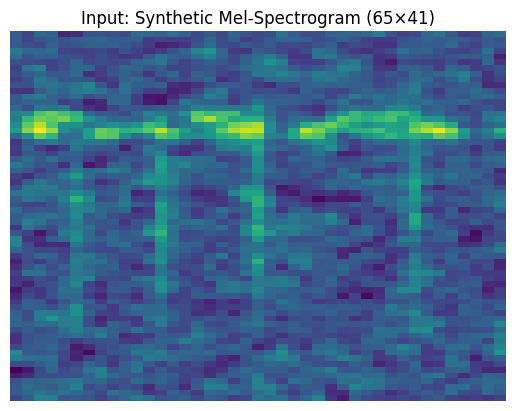

In [4]:

from scipy.signal import convolve2d

H, W = 65, 41
rng = np.random.default_rng(42)

# Base noise
spec = rng.normal(loc=0.0, scale=0.4, size=(H, W))

# Sinusoidal ridges across time
t = np.linspace(0, 1, W)
for k in [3, 5, 7]:
    row = int(H * (0.2 + 0.1 * k / 10.0))
    ridge = 0.8 * np.sin(2 * np.pi * k * t)
    ridge = (ridge - ridge.min()) / (ridge.max() - ridge.min() + 1e-8)  # 0..1
    ridge = ridge * 1.2
    spec[row:row+2, :] += ridge

# Vertical onset-like columns
for c in [5, 12, 20, 33]:
    col_strength = rng.uniform(0.8, 1.2)
    spec[:, c:c+1] += col_strength * np.hanning(H).reshape(-1, 1)

# Smooth a bit
kernel = np.array([[0.05, 0.1, 0.05],
                   [0.1,  0.4, 0.1 ],
                   [0.05, 0.1, 0.05]])
spec = convolve2d(spec, kernel, mode="same", boundary="symm")

# Z-score normalize
spec = (spec - spec.mean()) / (spec.std() + 1e-8)

# Torch tensor (B, C, H, W) = (1, 1, 65, 41)
x = torch.tensor(spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print_shape("Input", x)
show_map(x[0,0].detach().numpy(), "Input: Synthetic Mel-Spectrogram (65×41)")



## 2. Definir los módulos
Usamos dos bloques **Conv-BN-ReLU-Pool(3x3)-Dropout2d** con kernels 5×5 y 8 canales por simplicidad.
**Dropout2d** apaga canales completos (más visible para docencia).

In [5]:

c1, c2 = 8, 8
k1, k2 = 5, 5
p_drop = 0.5

conv1 = nn.Conv2d(1, c1, kernel_size=k1, padding=k1//2, bias=True)
bn1   = nn.BatchNorm2d(c1, affine=True)
pool1 = nn.MaxPool2d(kernel_size=3)      # stride=3 por defecto
do1   = nn.Dropout2d(p=p_drop)

conv2 = nn.Conv2d(c1, c2, kernel_size=k2, padding=k2//2, bias=True)
bn2   = nn.BatchNorm2d(c2, affine=True)
pool2 = nn.MaxPool2d(kernel_size=3)
do2   = nn.Dropout2d(p=p_drop)

# Modo entrenamiento para ver BN con estadísticas del batch y Dropout activo
conv1.train(); bn1.train(); pool1.train(); do1.train()
conv2.train(); bn2.train(); pool2.train(); do2.train()


Dropout2d(p=0.5, inplace=False)


## 3. Bloque 1
### 3.1 Conv1

After Conv1 shape: (1, 8, 65, 41)


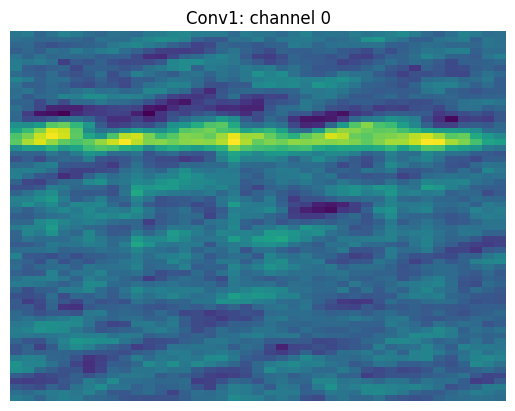

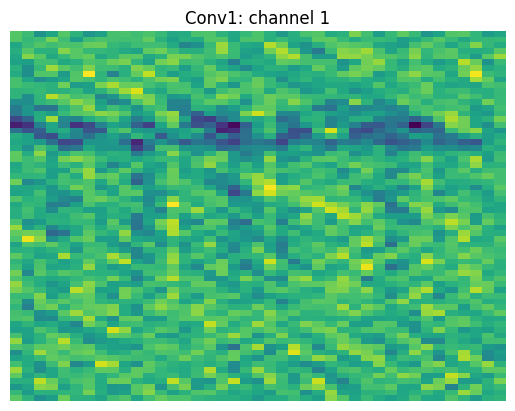

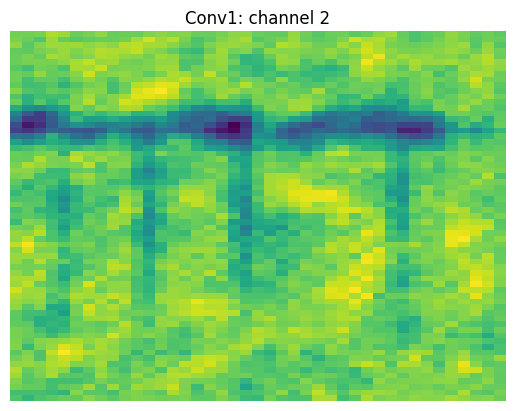

In [6]:

y1 = conv1(x)
print_shape("After Conv1", y1)

# Mostrar primeros tres canales si existen
for ch in range(min(3, y1.shape[1])):
    show_map(y1[0, ch].detach().numpy(), f"Conv1: channel {ch}")



### 3.2 BatchNorm1

After BN1 shape: (1, 8, 65, 41)


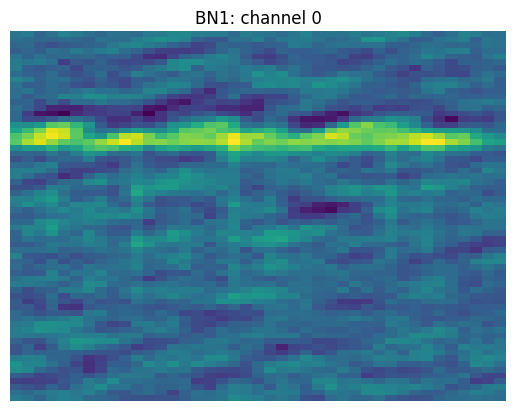

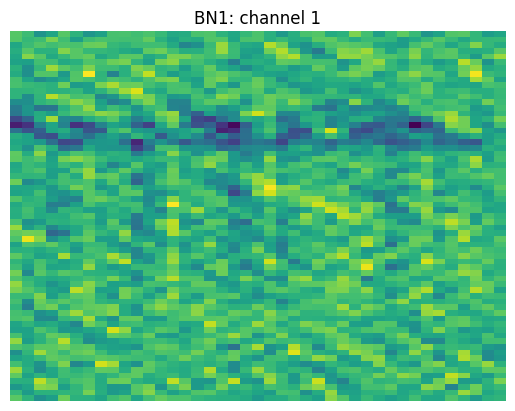

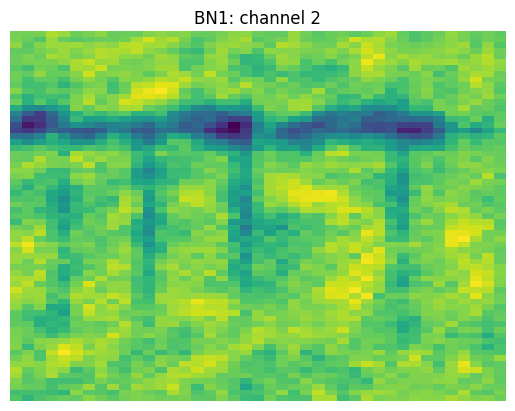

In [7]:

y2 = bn1(y1)
print_shape("After BN1", y2)
for ch in range(min(3, y2.shape[1])):
    show_map(y2[0, ch].detach().numpy(), f"BN1: channel {ch}")



### 3.3 ReLU1

After ReLU1 shape: (1, 8, 65, 41)


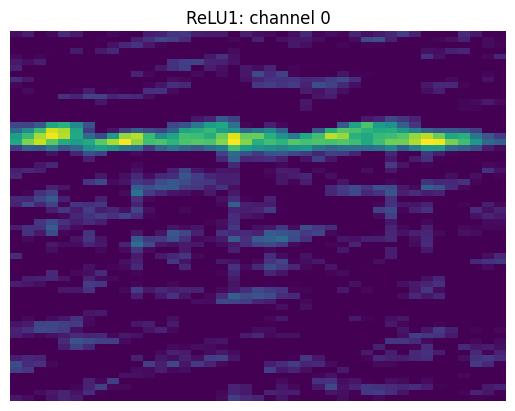

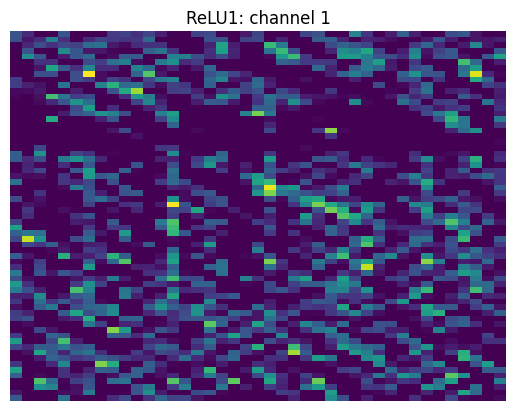

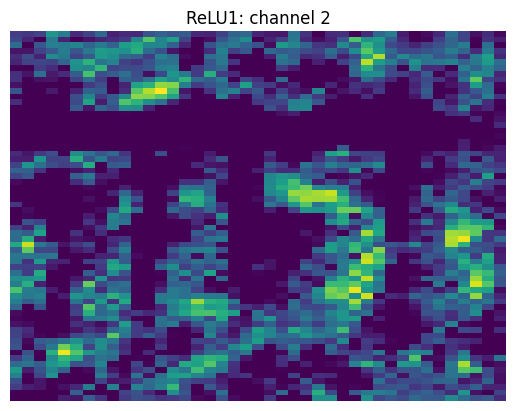

In [8]:

y3 = F.relu(y2, inplace=False)
print_shape("After ReLU1", y3)
for ch in range(min(3, y3.shape[1])):
    show_map(y3[0, ch].detach().numpy(), f"ReLU1: channel {ch}")



### 3.4 MaxPool1 (3×3)

After MaxPool1 shape: (1, 8, 21, 13)


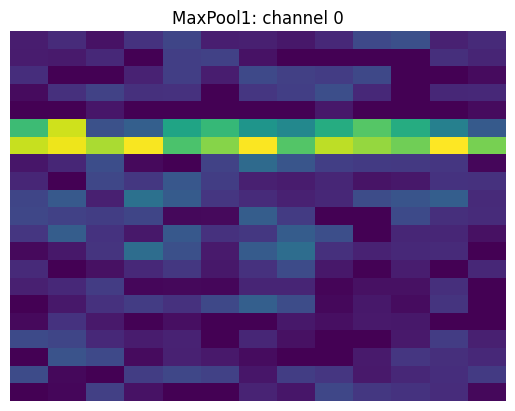

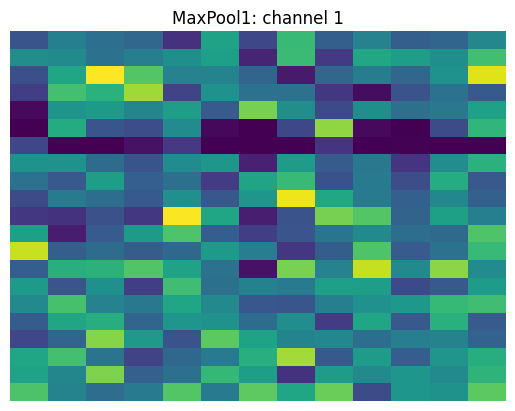

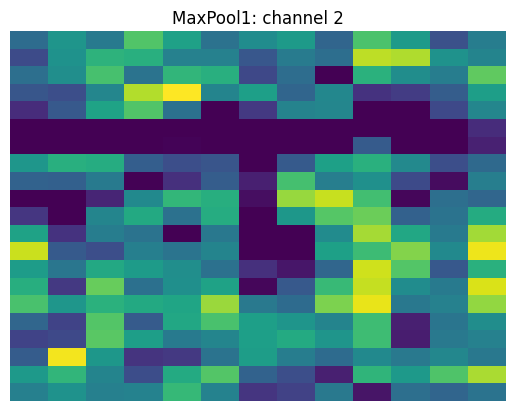

In [9]:

y4 = pool1(y3)
print_shape("After MaxPool1", y4)
for ch in range(min(3, y4.shape[1])):
    show_map(y4[0, ch].detach().numpy(), f"MaxPool1: channel {ch}")



### 3.5 Dropout1 (canal-wise)

After Dropout1 shape: (1, 8, 21, 13)


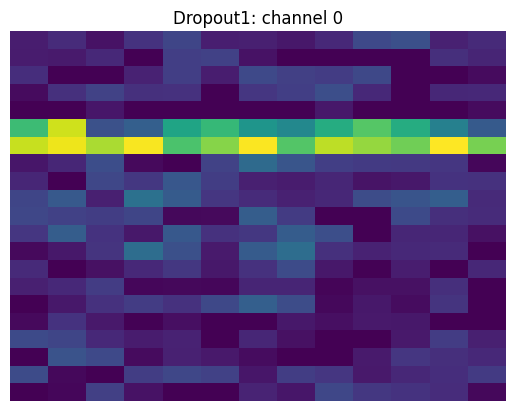

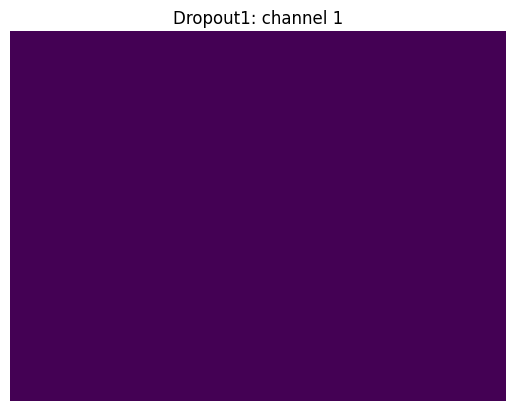

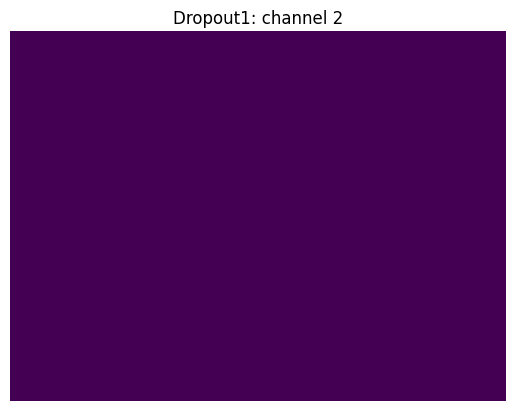

In [10]:

y5 = do1(y4)
print_shape("After Dropout1", y5)
for ch in range(min(3, y5.shape[1])):
    show_map(y5[0, ch].detach().numpy(), f"Dropout1: channel {ch}")



## 4. Bloque 2
### 4.1 Conv2

After Conv2 shape: (1, 8, 21, 13)


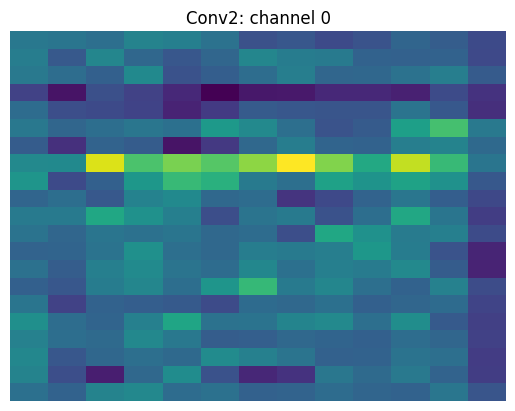

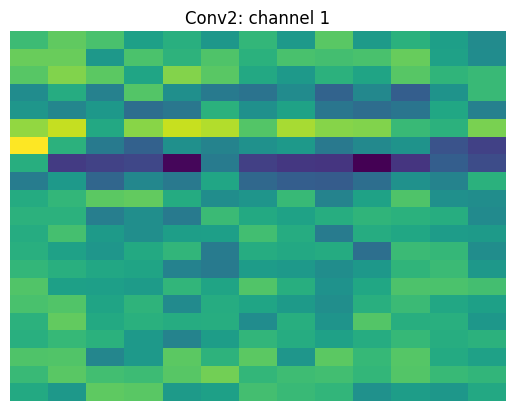

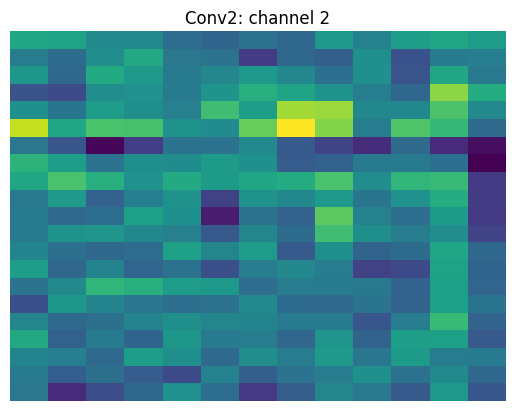

In [11]:

y6 = conv2(y5)
print_shape("After Conv2", y6)
for ch in range(min(3, y6.shape[1])):
    show_map(y6[0, ch].detach().numpy(), f"Conv2: channel {ch}")



### 4.2 BatchNorm2

After BN2 shape: (1, 8, 21, 13)


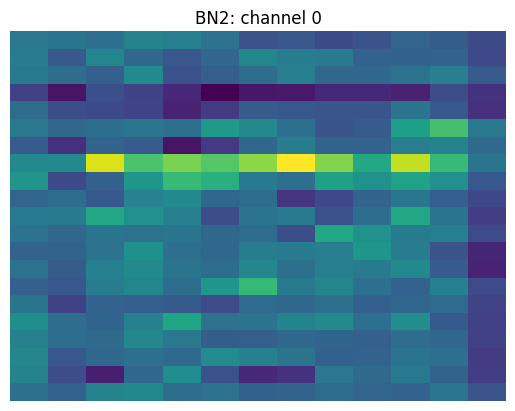

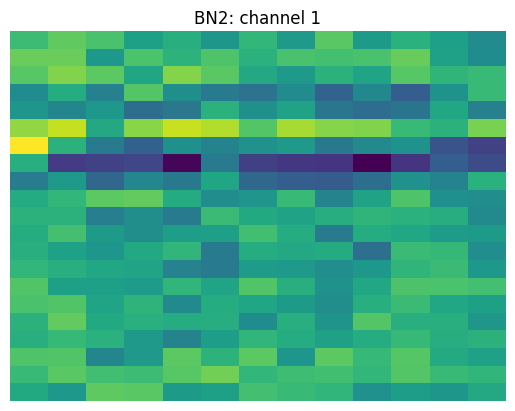

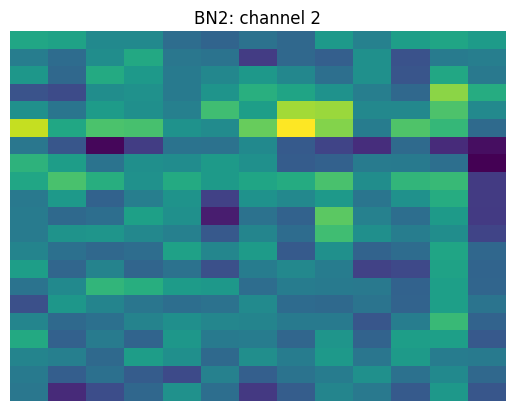

In [12]:

y7 = bn2(y6)
print_shape("After BN2", y7)
for ch in range(min(3, y7.shape[1])):
    show_map(y7[0, ch].detach().numpy(), f"BN2: channel {ch}")



### 4.3 ReLU2

After ReLU2 shape: (1, 8, 21, 13)


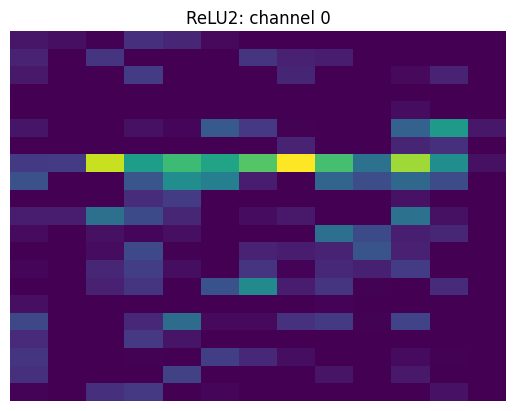

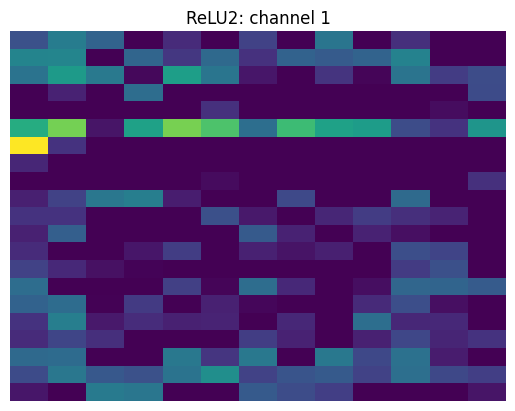

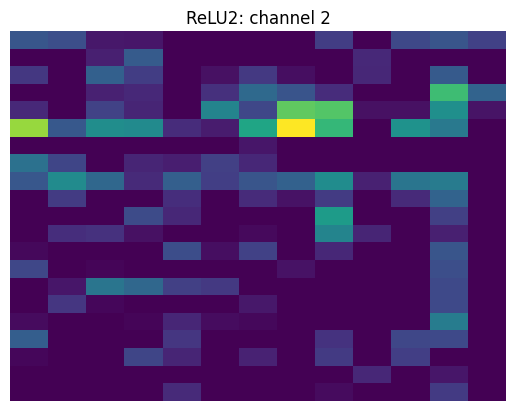

In [13]:

y8 = F.relu(y7, inplace=False)
print_shape("After ReLU2", y8)
for ch in range(min(3, y8.shape[1])):
    show_map(y8[0, ch].detach().numpy(), f"ReLU2: channel {ch}")



### 4.4 MaxPool2 (3×3)

After MaxPool2 shape: (1, 8, 7, 4)


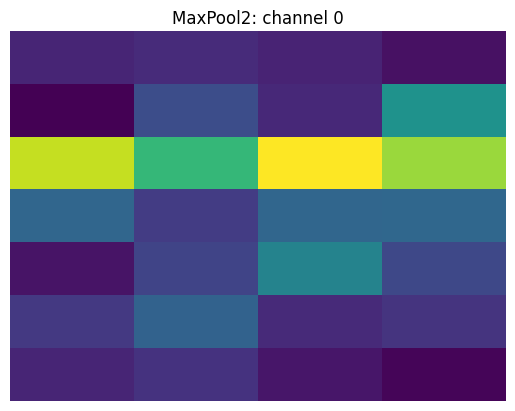

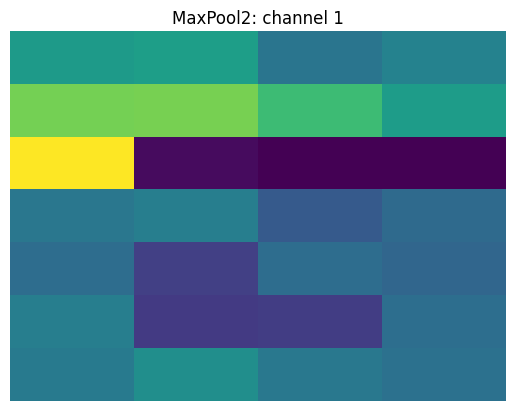

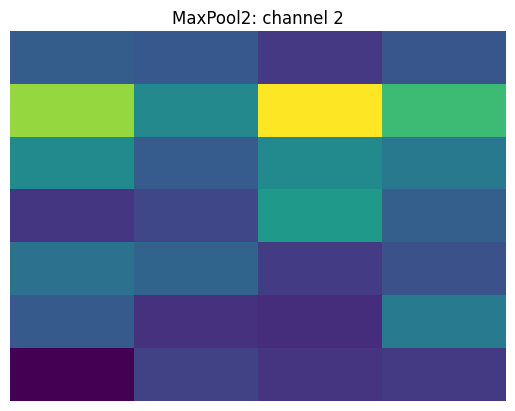

In [14]:

y9 = pool2(y8)
print_shape("After MaxPool2", y9)
for ch in range(min(3, y9.shape[1])):
    show_map(y9[0, ch].detach().numpy(), f"MaxPool2: channel {ch}")



### 4.5 Dropout2 (canal-wise)

After Dropout2 shape: (1, 8, 7, 4)


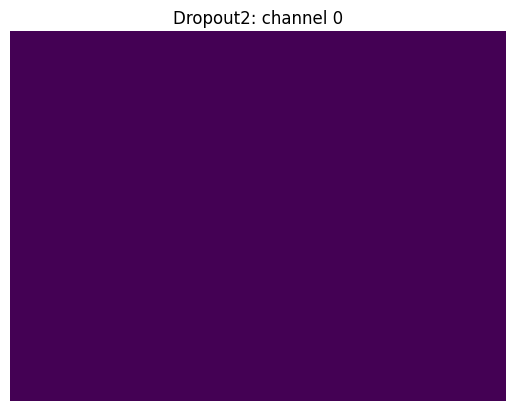

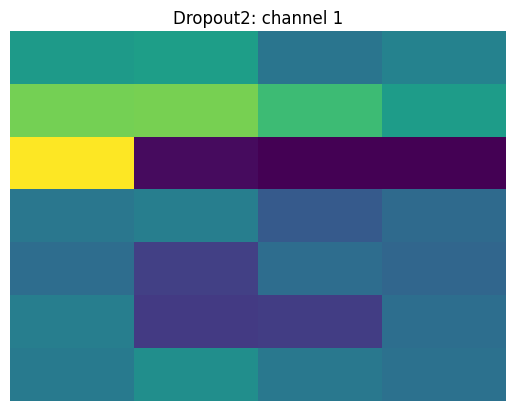

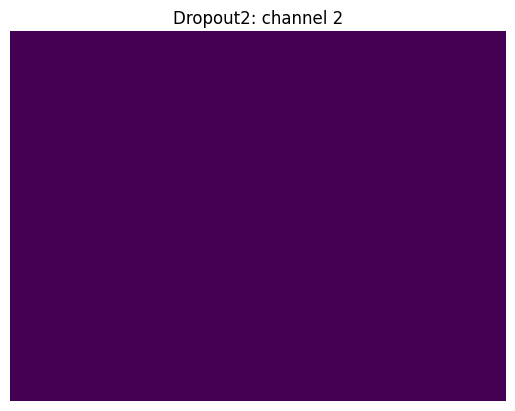

In [15]:

y10 = do2(y9)
print_shape("After Dropout2", y10)
for ch in range(min(3, y10.shape[1])):
    show_map(y10[0, ch].detach().numpy(), f"Dropout2: channel {ch}")



## 5. Flatten (vector final para las cabezas densas)

In [16]:

y_flat = torch.flatten(y10, 1)
print_shape("After Flatten", y_flat)
y_flat.shape


After Flatten shape: (1, 224)


torch.Size([1, 224])


## 6. (Opcional) Comparar **train vs eval**
En `eval()`, **Dropout** se desactiva y **BatchNorm** usa estadísticas acumuladas.
Ejecuta esta celda para ver cómo cambian las salidas del primer bloque.


Eval - After Conv1 shape: (1, 8, 65, 41)
Eval - After BN1 shape: (1, 8, 65, 41)
Eval - After ReLU1 shape: (1, 8, 65, 41)
Eval - After MaxPool1 shape: (1, 8, 21, 13)
Eval - After Dropout1 (no effect in eval) shape: (1, 8, 21, 13)


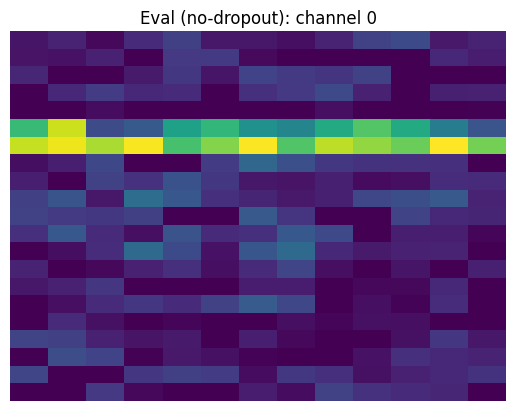

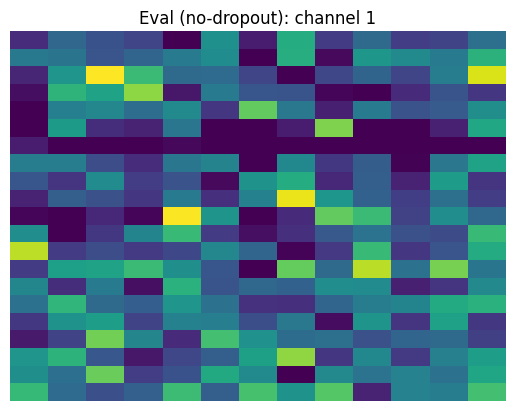

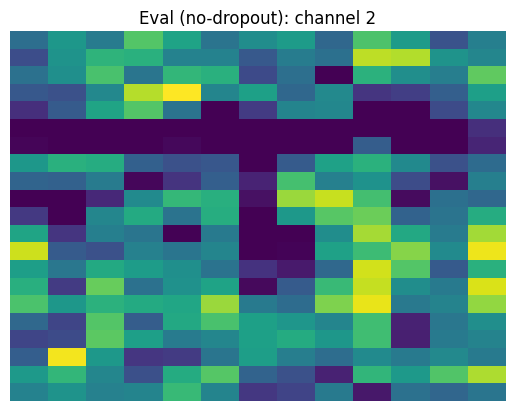

In [17]:

# Cambiar a eval
conv1.eval(); bn1.eval(); pool1.eval(); do1.eval()
with torch.no_grad():
    y1_eval = conv1(x)
    y2_eval = bn1(y1_eval)
    y3_eval = F.relu(y2_eval, inplace=False)
    y4_eval = pool1(y3_eval)
    y5_eval = do1(y4_eval)  # Dropout2d en eval no apaga canales

print_shape("Eval - After Conv1", y1_eval)
print_shape("Eval - After BN1", y2_eval)
print_shape("Eval - After ReLU1", y3_eval)
print_shape("Eval - After MaxPool1", y4_eval)
print_shape("Eval - After Dropout1 (no effect in eval)", y5_eval)

for ch in range(min(3, y5_eval.shape[1])):
    show_map(y5_eval[0, ch].detach().numpy(), f"Eval (no-dropout): channel {ch}")
